In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 

In [4]:
import pandas as pd
import numpy as np

def analyze_betting_quotes(df,quote_cutoff, index_A=1, index_B=2, index_C=3, minimum_game_length=100, verbose = True):
    if len(df) < minimum_game_length:
        if verbose : print("Not enough data")
        return False
    
    column_A = df.columns[index_A]
    column_B = df.columns[index_B]
    column_C = df.columns[index_C]
    
    valid_quotes = {column_A: [], column_B: [], column_C: []}
    
    for index, row in df.iterrows():
        for col in [column_A, column_B, column_C]:
            if not np.isnan(row[col]) and len(valid_quotes[col]) < 2:
                valid_quotes[col].append(row[col])
                
        if all(len(quotes) == 2 for quotes in valid_quotes.values()):
            break
    
    if not all(len(quotes) == 2 for quotes in valid_quotes.values()):
        if verbose : print("Did not find at least to quotes for each outcome. Not processing")
        return False
    
    min_first_quote = min(valid_quotes[column_A][1], valid_quotes[column_B][1], valid_quotes[column_C][1])
    
    if min_first_quote < quote_cutoff:
        if verbose : print("Beginning of game was more uncertain than cutoff. Min quote was {} ".format(min_first_quote))
        return False
    
    second_quotes = {col: quotes[1] for col, quotes in valid_quotes.items()}
    sorted_columns = sorted(second_quotes, key=second_quotes.get)
    
    df.rename(columns={sorted_columns[0]: 'favourite',
                       sorted_columns[1]: 'runner_up',
                       sorted_columns[2]: 'runner_runner_up'},
              inplace=True)
    
    return True


In [5]:
file_folder = '/Users/mohamedbenmosbah/PythonFC/data/'

In [6]:
def did_favourite_win(processed_df):
    last_valid_quotes = {}

    for col in ['favourite', 'runner_up', 'runner_runner_up']:
        for value in reversed(processed_df[col]):
            if not np.isnan(value):
                last_valid_quotes[col] = value
                break

    winner = min(last_valid_quotes, key=last_valid_quotes.get)
    return winner == 'favourite'

In [25]:
def analyse_games_in_folder(quote_cutoff,file_folder=file_folder):
    total_games_analysed = 0
    times_favourite_won = 0
    files = [f for f in os.listdir(file_folder)]
    for file in files:
        try:
            df = pd.read_parquet(file_folder+file)
        except:
            print(f'Failed to read {file}')
            continue
        analysis_successfull = analyze_betting_quotes(df,quote_cutoff,verbose=False)
        if analysis_successfull:
            total_games_analysed += 1
            times_favourite_won += int(did_favourite_win(df))
    return times_favourite_won/total_games_analysed

In [26]:
quote_cutoff_values = [1,1.5,2,2.5]
# realised_odds is the realised odds corresponding to the "observed" frequency of wins of the favourite
realised_odds = [] 

for quote_cutoff in quote_cutoff_values:
    realised_odds.append(1/analyse_games_in_folder(quote_cutoff))

Failed to read .DS_Store
Failed to read raw
Failed to read .DS_Store
Failed to read raw
Failed to read .DS_Store
Failed to read raw
Failed to read .DS_Store
Failed to read raw


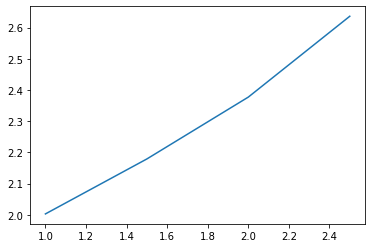

In [27]:
plt.plot(quote_cutoff_values,realised_odds)
plt.show()

In [28]:
# Toy example : Vraiment truc codé ultra vite et a la zeub mais ca a l'air de dire que quand la cote est vrmt trop basse au 
# debut du match, il faut se mettre short de l'issue la plus chere. A en croire ca, y a aucune raison de penser qu'une 
# equipe a plus de 50% de gagner avant un match (statisiquement et en general bien sur)